# BART Project

In this project, we will analyze the Bay Area Rapid Transit (BART) system in San Francisco to determine which station has the highest ridership and at what times of the day passengers can sit comfortably during their journeys.

We will seek answers to the following Data Analytics questions:

- **Which BART station is the busiest?**
- **What is the least popular BART route?**
- **When is the best time to go to San Francisco from Berkeley if you want to find a seat?**
- **Which day of the week is the busiest?**
- **How many people take the BART late at night?**

After answering these questions, we will calculate the distances between each station and build a deep learning regression model that can predict the number of people commuting to work by BART between any two stations. Following this, we will address the following questions:

- **How would you approach that?**
- **What additional data would you need?**
- **How would you want the city or BART officials to use your data?**

This dataset contains BART data from the years 2016 and 2017. It includes station names, addresses, and the number of passengers who boarded each station on various dates.

The dataset used for this project has been provided by the BART organization and is obtained from kaggle.com.

<img src= 'https://lahstalon.org/wp-content/uploads/2023/06/bart-900x677.png'>

### Importing the necessary packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None) 
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

### Importing three separate data files: one containing data from 2016, one with data from 2017, and the other with station information

In [2]:
df_2016=pd.read_csv('date-hour-soo-dest-2016.csv')
df_2017=pd.read_csv('date-hour-soo-dest-2017.csv')
df_station=pd.read_csv('station_info.csv')

### EDA - Exploratoy data analysis and merging three data files

In [3]:
df_2016.head()

,Origin,Destination,Throughput,DateTime
0,12TH,12TH,1,2016-01-01 00:00:00
1,12TH,16TH,1,2016-01-01 00:00:00
2,12TH,24TH,4,2016-01-01 00:00:00
3,12TH,ASHB,4,2016-01-01 00:00:00
4,12TH,BALB,2,2016-01-01 00:00:00


In [4]:
df_2017.head()

,Origin,Destination,Throughput,DateTime
0,12TH,19TH,1,2017-01-01 00:00:00
1,12TH,24TH,2,2017-01-01 00:00:00
2,12TH,BAYF,1,2017-01-01 00:00:00
3,12TH,CIVC,5,2017-01-01 00:00:00
4,12TH,COLS,2,2017-01-01 00:00:00


In [5]:
df_station.head()

,Abbreviation,Description,Location,Name
0,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH)
1,16TH,"2000 Mission Street, San Francisco CA 94110<br...","-122.419694,37.765062,0",16th St. Mission (16TH)
2,19TH,"1900 Broadway, Oakland CA 94612<br />19th Stre...","-122.268602,37.808350,0",19th St. Oakland (19TH)
3,24TH,"2800 Mission Street, San Francisco CA 94110<br...","-122.418143,37.752470,0",24th St. Mission (24TH)
4,ASHB,"3100 Adeline Street, Berkeley CA 94703<br />As...","-122.270062,37.852803,0",Ashby (ASHB)


In [6]:
merged_df = pd.concat([df_2016, df_2017])

In [7]:
df = pd.merge(merged_df, df_station, left_on='Origin', right_on='Abbreviation')

In [8]:
df.head()

,Origin,Destination,Throughput,DateTime,Abbreviation,Description,Location,Name
0,12TH,12TH,1,2016-01-01 00:00:00,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH)
1,12TH,16TH,1,2016-01-01 00:00:00,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH)
2,12TH,24TH,4,2016-01-01 00:00:00,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH)
3,12TH,ASHB,4,2016-01-01 00:00:00,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH)
4,12TH,BALB,2,2016-01-01 00:00:00,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH)


In [9]:
df.shape

(13269767, 8)

In [10]:
df.isnull().sum()

Origin          0
Destination     0
Throughput      0
DateTime        0
Abbreviation    0
Description     0
Location        0
Name            0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13269767 entries, 0 to 13269766
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Origin        object
 1   Destination   object
 2   Throughput    int64 
 3   DateTime      object
 4   Abbreviation  object
 5   Description   object
 6   Location      object
 7   Name          object
dtypes: int64(1), object(7)
memory usage: 809.9+ MB


### Feature Engineering

In [12]:
df['DateTime']=pd.to_datetime(df['DateTime'])

df['Year']=df['DateTime'].dt.year
df['Month']=df['DateTime'].dt.month
df['Day']=df['DateTime'].dt.day
df['Month']=df['DateTime'].dt.month_name()
df['Day']=df['DateTime'].dt.day_name()
df['Hour']=df['DateTime'].dt.hour

In [13]:
df.head()

,Origin,Destination,Throughput,DateTime,Abbreviation,Description,Location,Name,Year,Month,Day,Hour
0,12TH,12TH,1,2016-01-01,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH),2016,January,Friday,0
1,12TH,16TH,1,2016-01-01,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH),2016,January,Friday,0
2,12TH,24TH,4,2016-01-01,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH),2016,January,Friday,0
3,12TH,ASHB,4,2016-01-01,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH),2016,January,Friday,0
4,12TH,BALB,2,2016-01-01,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH),2016,January,Friday,0


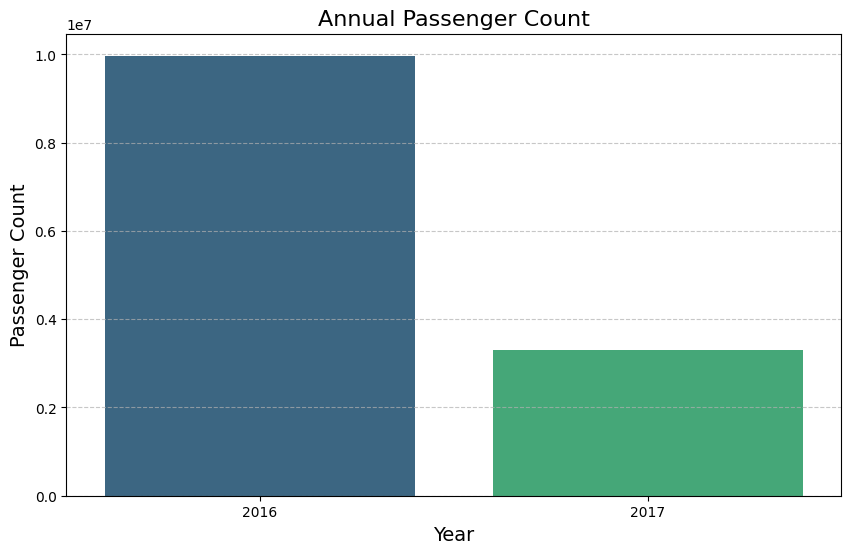

In [14]:
#annual trend graph
plt.figure(figsize=(10, 6))
yearly_data = df.groupby('Year').size().reset_index(name='Count')
sns.barplot(x='Year', y='Count', data=yearly_data, palette='viridis')
plt.title('Annual Passenger Count', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

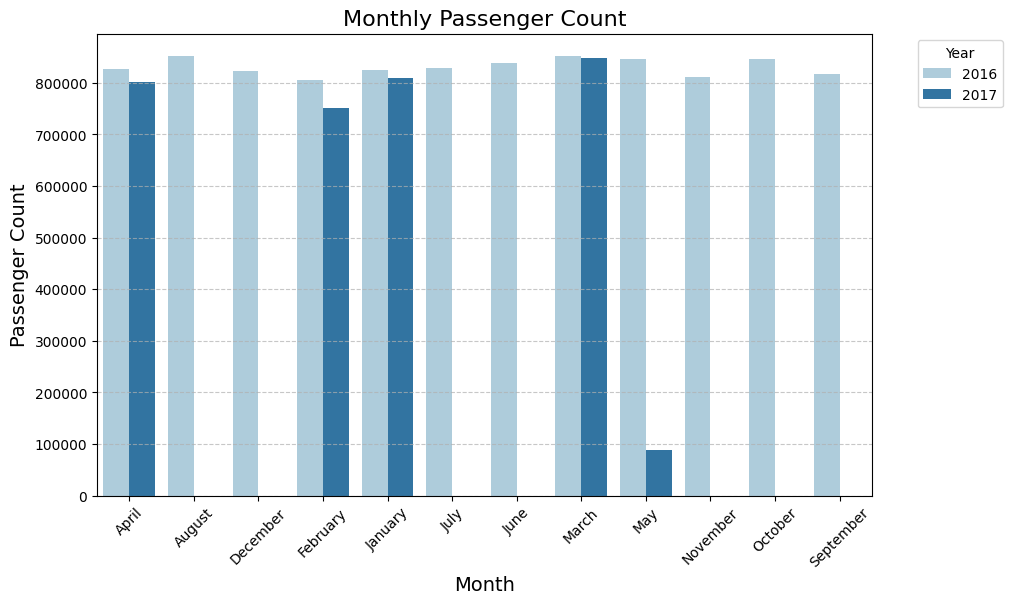

In [15]:
#monthly trend graph
plt.figure(figsize=(10, 6))
monthly_data = df.groupby(['Year', 'Month']).size().unstack().reset_index()
monthly_data = monthly_data.melt(id_vars='Year', var_name='Month', value_name='Count')
sns.barplot(x='Month', y='Count', hue='Year', data=monthly_data, palette='Paired')
plt.title('Monthly Passenger Count', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

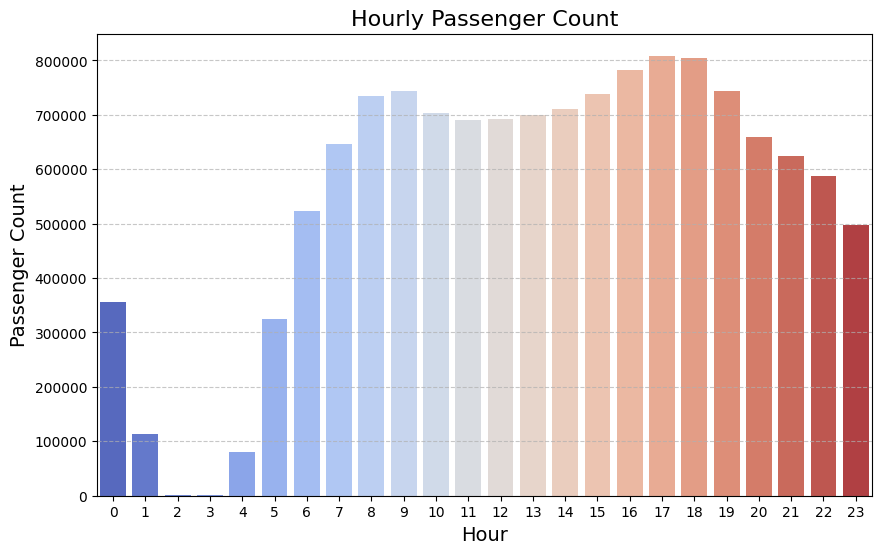

In [16]:
#hourly distribution graph
plt.figure(figsize=(10, 6))
hourly_data = df.groupby('Hour').size().reset_index(name='Count')
sns.barplot(x='Hour', y='Count', data=hourly_data, palette='coolwarm')
plt.title('Hourly Passenger Count', fontsize=16)
plt.xlabel('Hour', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

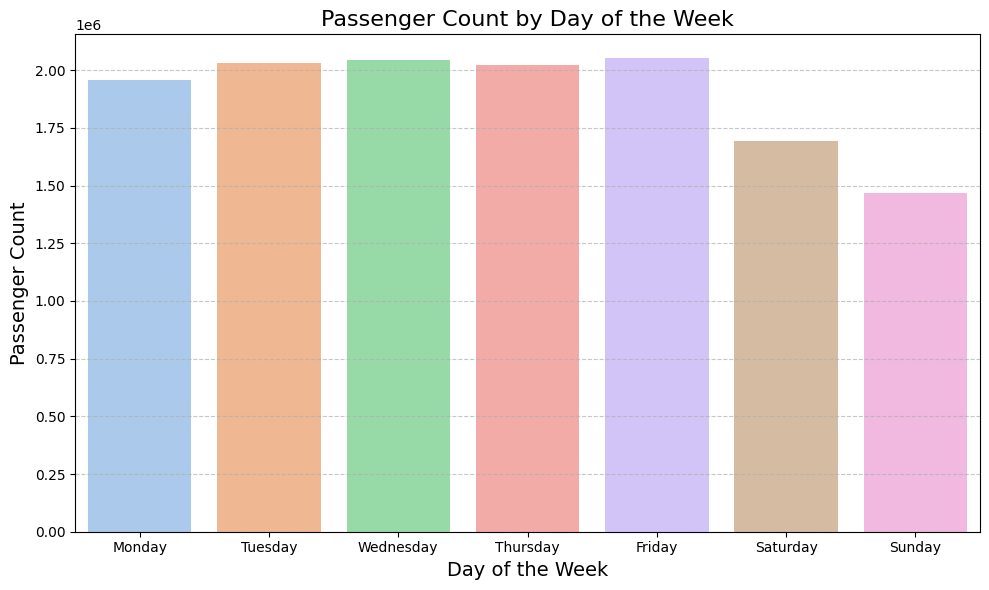

In [17]:
#daily distribution graph
plt.figure(figsize=(10, 6))
sns.countplot(x='Day', data=df, palette='pastel', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Passenger Count by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
df['Longitude'] = df['Location'].apply(lambda x: float(x.split(",")[0]))
df['Latitude'] = df['Location'].apply(lambda x: float(x.split(",")[1]))

In [19]:
df.drop(['Location','DateTime','Abbreviation','Description','Name'] ,axis=1, inplace=True)

In [20]:
df.sample(10)

,Origin,Destination,Throughput,Year,Month,Day,Hour,Longitude,Latitude
4523499,DBRK,RICH,11,2017,April,Wednesday,11,-122.268133,37.870104
2191742,BAYF,POWL,27,2016,June,Wednesday,5,-122.126514,37.696924
6294728,GLEN,FTVL,2,2016,June,Friday,21,-122.433817,37.733064
6123650,FTVL,FRMT,17,2017,January,Friday,9,-122.224175,37.774836
11642701,SFIA,ORIN,3,2016,August,Thursday,15,-122.392409,37.615966
12938892,WDUB,PLZA,1,2017,January,Thursday,15,-121.928240,37.699756
5809626,FRMT,UCTY,16,2017,February,Monday,16,-121.976608,37.557465
1153991,24TH,WOAK,17,2016,February,Friday,15,-122.418143,37.752470
125009,12TH,GLEN,1,2016,June,Saturday,17,-122.271450,37.803768
5351625,EMBR,DALY,91,2016,September,Friday,19,-122.397020,37.792874


In [21]:
df['Route'] = df['Origin'] + ' - ' + df['Destination']

### Answering the Data Analytics Questions

- ***Which BART station is the busiest?***

The busiest BART station: MONT, Throughput: 16107314


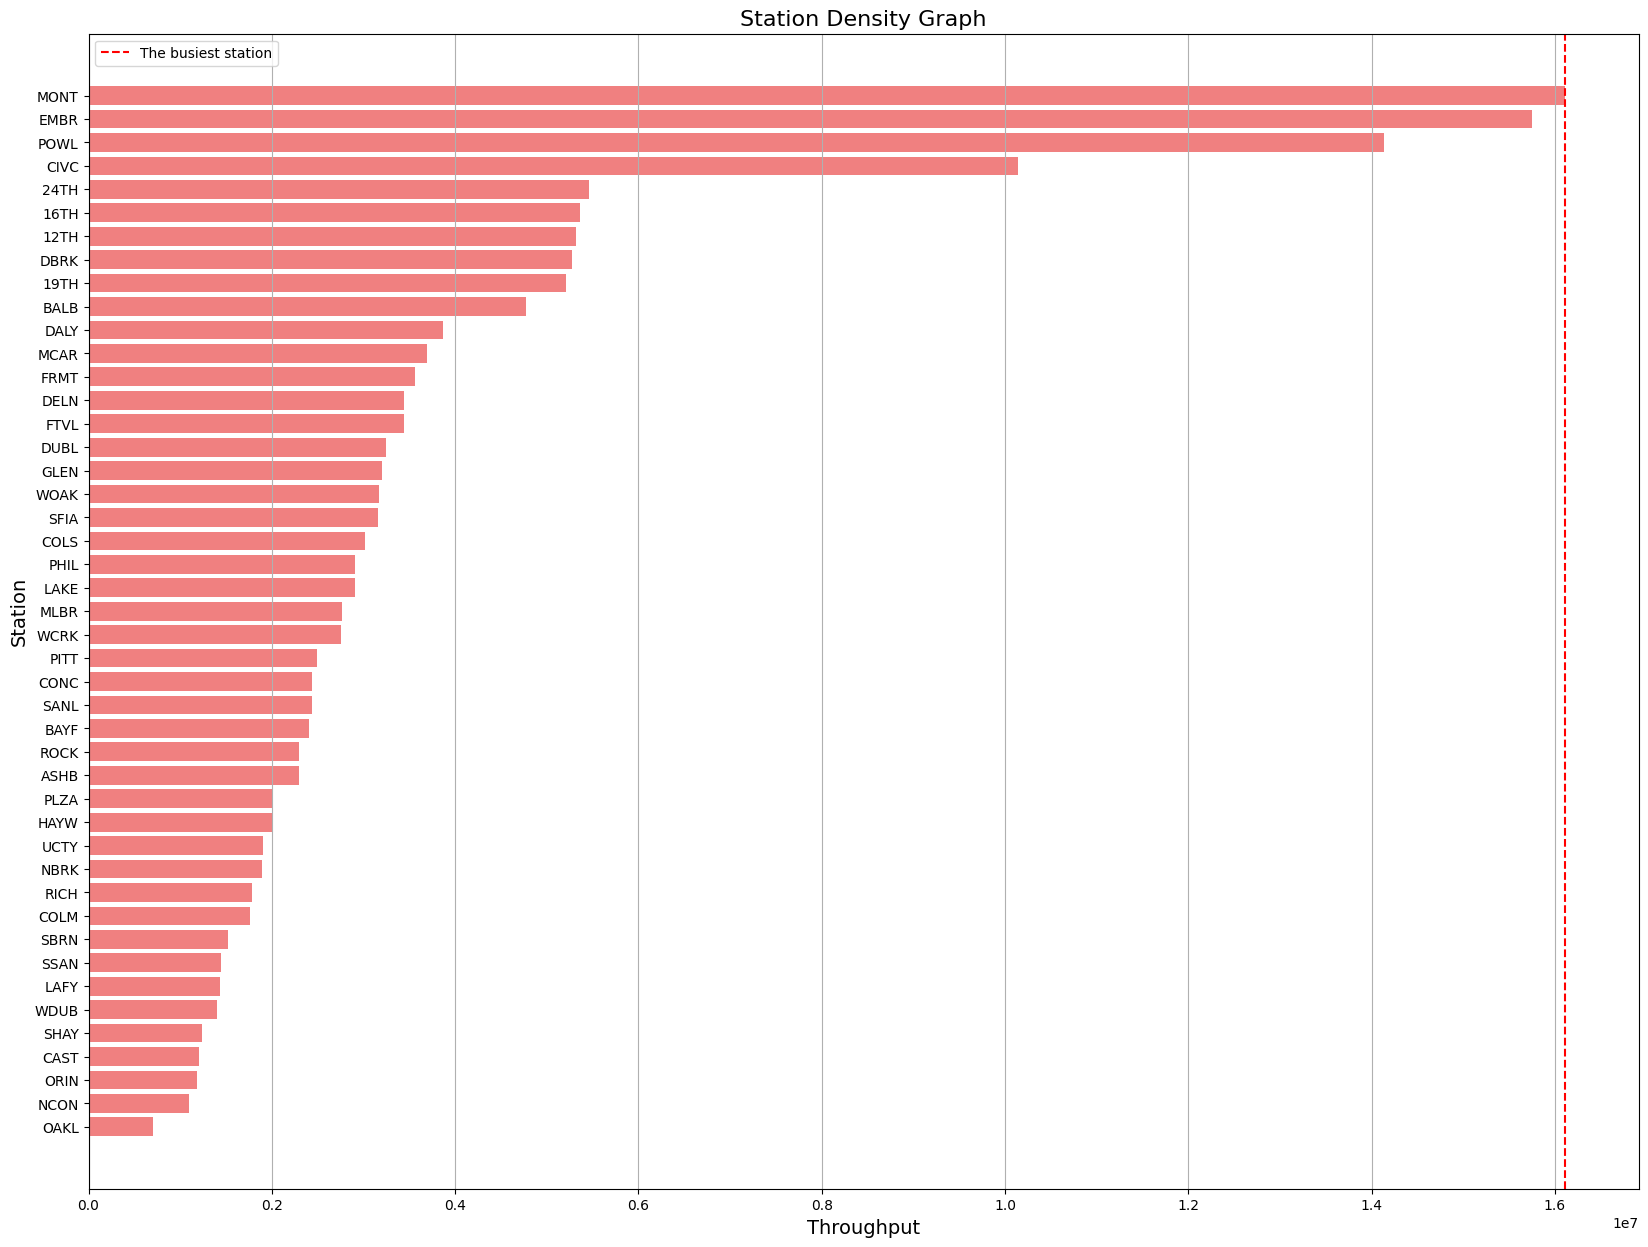

In [22]:
origin_throughput = df.groupby('Origin')['Throughput'].sum().reset_index() #calculating the total throughput based on the origin

busiest_station = origin_throughput.loc[origin_throughput['Throughput'].idxmax()] #finding the busiest station
print(f"The busiest BART station: {busiest_station['Origin']}, Throughput: {busiest_station['Throughput']}")

origin_throughput = origin_throughput.sort_values(by='Throughput', ascending=True)
plt.figure(figsize=(20, 15))
plt.barh(origin_throughput['Origin'], origin_throughput['Throughput'], color='lightcoral')
plt.axvline(x=busiest_station['Throughput'], color='red', linestyle='--', label='The busiest station')
plt.title('Station Density Graph', fontsize=16)
plt.xlabel('Throughput', fontsize=14)
plt.ylabel('Station', fontsize=14)
plt.legend()
plt.grid(axis='x')
plt.show()

- ***What is the least popular BART route?***

Least popular BART route: SSAN to WSPR, Throughput: 41


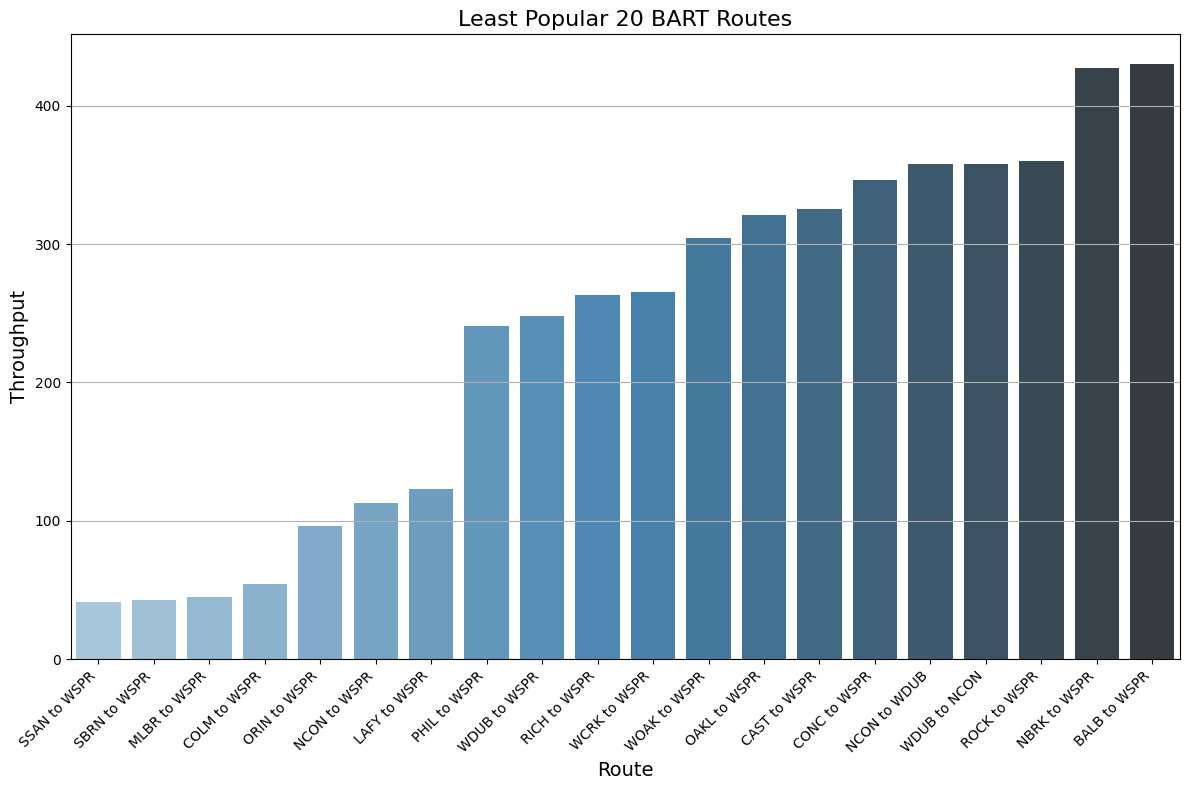

In [23]:
route_throughput = df.groupby(['Origin', 'Destination'])['Throughput'].sum().reset_index() #calculating the total throughput by origin and destination
least_popular_route = route_throughput.loc[route_throughput['Throughput'].idxmin()] #finding the least popular route
print(f"Least popular BART route: {least_popular_route['Origin']} to {least_popular_route['Destination']}, Throughput: {least_popular_route['Throughput']}")

least_popular_routes = route_throughput.nsmallest(20, 'Throughput') #sorting the routes by throughput in ascending order and select the least popular 20
least_popular_routes['Route'] = least_popular_routes['Origin'] + ' to ' + least_popular_routes['Destination'] #creating a new column for the combined route

plt.figure(figsize=(12, 8))
sns.barplot(data=least_popular_routes, x='Route', y='Throughput', palette='Blues_d')
plt.xticks(rotation=45, ha='right')
plt.title('Least Popular 20 BART Routes', fontsize=16)
plt.xlabel('Route', fontsize=14)
plt.ylabel('Throughput', fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

- ***When is the best time to go to San Francisco from Berkeley if you want to find a seat?***

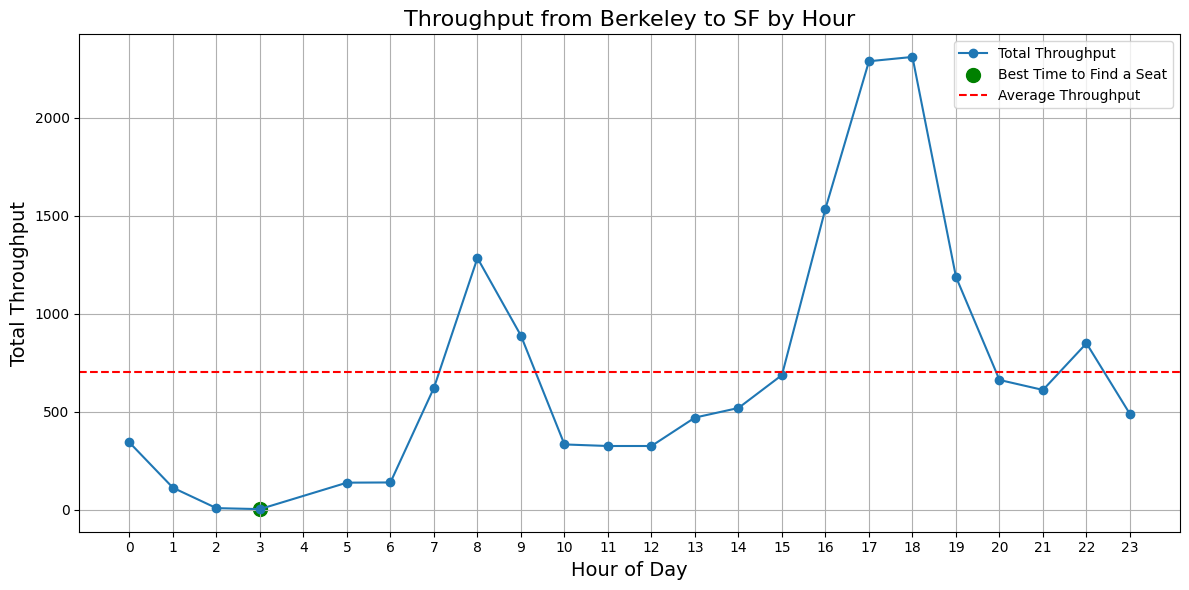

In [47]:
berkeley_to_sf = df[(df['Origin'] == 'DBRK') & (df['Destination'] == 'SSAN')] #filtering the data for trips from berkeley to san francisco
throughput_by_time = berkeley_to_sf.groupby('Hour')['Throughput'].sum().reset_index() #grouping by hour and sum the throughput

plt.figure(figsize=(12, 6))
plt.plot(throughput_by_time['Hour'], throughput_by_time['Throughput'], marker='o', label='Total Throughput')
plt.title('Throughput from Berkeley to SF by Hour', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Total Throughput', fontsize=14)
plt.xticks(range(24))
plt.grid()

best_time_row = throughput_by_time.loc[throughput_by_time['Throughput'].idxmin()] #finding the hour with the lowest throughput value
best_hour = best_time_row['Hour']
best_throughput = best_time_row['Throughput']

plt.scatter(best_hour, best_throughput, color='green', s=100, label='Best Time to Find a Seat')
threshold = throughput_by_time['Throughput'].mean()
plt.axhline(y=threshold, color='r', linestyle='--', label='Average Throughput')
plt.legend()
plt.tight_layout()
plt.show()

- ***Which day of the week is the busiest?***

Busiest day of the week: Wednesday, Total Throughput: 30661163


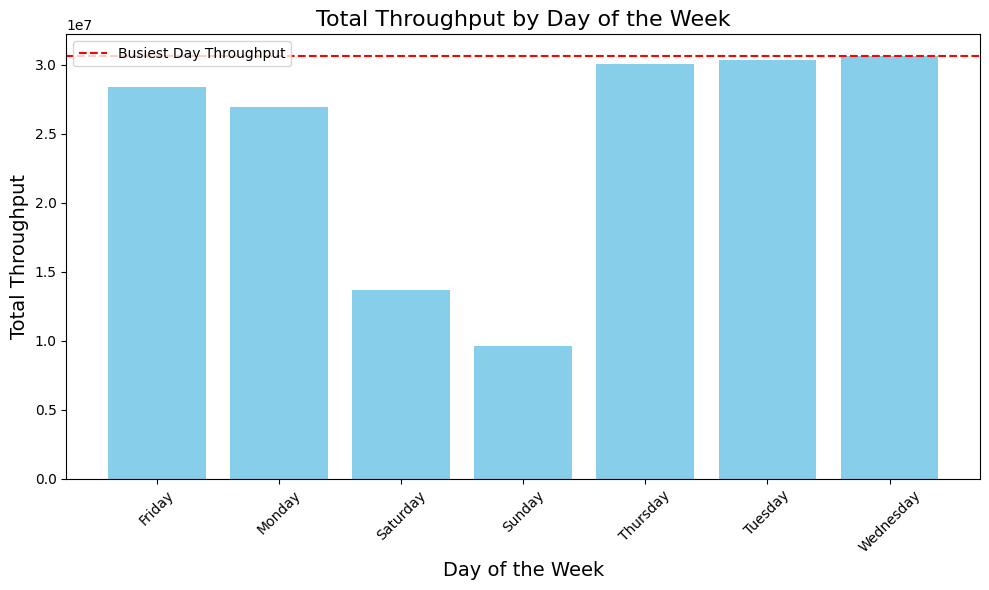

In [25]:
busiest_day = df.groupby('Day')['Throughput'].sum().reset_index() #calculating the total throughput by days

busiest_day_info = busiest_day.loc[busiest_day['Throughput'].idxmax()] #finding the busiest day
print(f"Busiest day of the week: {busiest_day_info['Day']}, Total Throughput: {busiest_day_info['Throughput']}")

plt.figure(figsize=(10, 6))
plt.bar(busiest_day['Day'], busiest_day['Throughput'], color='skyblue')
plt.title('Total Throughput by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Total Throughput', fontsize=14)
plt.xticks(rotation=45)
plt.axhline(y=busiest_day_info['Throughput'], color='r', linestyle='--', label='Busiest Day Throughput')
plt.legend()
plt.tight_layout()
plt.show()

- ***How many people take the BART late at night?***

In [26]:
late_night_hours = pd.concat([df[df['Hour'] >= 0], df[df['Hour'] < 6]]) #defining the nighttime hours
late_night_throughput = late_night_hours['Throughput'].sum() #calculating the total throughput during nighttime hours
print(f"Total number of people taking BART late at night: {late_night_throughput}")

Total number of people taking BART late at night: 173550251


### Answering the Data Science Questions

- ***Compute the straight line distance between every station***

In [27]:
df['la_radians'] = np.radians(df['Latitude'])
df['lo_radians'] = np.radians(df['Longitude']) #converting the latitude and the longitude to radians

unique_stations = df.drop_duplicates(subset=['Origin']) #finding the unique stations

coordinates = unique_stations[['la_radians', 'lo_radians']].to_numpy() #transferring the coordinates of the stations to a numpy array

dist_matrix_radians = haversine_distances(coordinates, coordinates) #calculating the haversine distances

dist_matrix_km = dist_matrix_radians * 6371 #converting distances from radians to km

df_dist_matrix = pd.DataFrame(
    dist_matrix_km,
    index=unique_stations['Origin'],
    columns=unique_stations['Origin'] #converting the distance matrix to a dataframe
)

In [28]:
df_dist_matrix

Origin,12TH,16TH,19TH,24TH,ASHB,BALB,BAYF,CAST,CIVC,COLM,COLS,CONC,DALY,DBRK,DELN,DUBL,EMBR,FRMT,FTVL,GLEN,HAYW,LAFY,LAKE,MCAR,MLBR,MONT,NBRK,NCON,OAKL,ORIN,PHIL,PITT,PLZA,POWL,RICH,ROCK,SANL,SBRN,SFIA,SHAY,SSAN,UCTY,WCRK,WDUB,WOAK
Origin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12TH,0.000000,13.720175,0.567617,14.097927,5.453806,17.972899,17.421986,21.318066,12.818548,21.651800,8.602724,28.452150,20.488348,7.381976,14.064957,34.641522,11.099285,37.726994,5.254274,16.294042,22.027147,16.279546,0.930228,2.839447,24.795767,11.500185,7.876464,30.993614,11.334582,11.315857,23.450324,37.305931,11.254330,12.186511,16.442537,4.881371,13.315746,22.428251,23.437267,26.644817,21.698728,32.578345,21.179219,32.315075,2.084928
16TH,13.720175,0.000000,14.123076,1.406790,16.370223,5.417745,26.873362,31.369785,1.703137,9.834954,19.629420,41.399854,7.862292,17.710613,19.956444,46.313509,3.678977,45.322092,17.219854,3.768466,31.123107,29.571877,14.036737,15.184031,18.552504,3.163421,17.025981,43.624344,19.134809,24.249960,36.740696,50.306911,18.615264,2.391407,19.977128,17.236833,23.259691,14.158399,16.751655,35.047867,11.411739,40.370112,34.647001,43.824988,11.806930
19TH,0.567617,14.123076,0.000000,14.537177,4.944611,18.449743,17.594397,21.423040,13.176704,22.162579,8.759155,27.927226,20.972364,6.866855,13.652407,34.575547,11.413346,37.927682,5.396993,16.761912,22.193837,15.772063,1.294459,2.307486,25.363052,11.827735,7.411705,30.454558,11.680862,10.773359,22.948482,36.787537,10.815966,12.530541,16.099056,4.316179,13.491787,22.989786,24.004818,26.832791,22.238484,32.780913,20.697326,32.267711,2.363310
24TH,14.097927,1.406790,14.537177,0.000000,17.138578,4.296647,26.382151,30.899845,3.051922,8.647687,19.454198,42.092373,6.828586,18.567582,21.157028,45.989716,4.861216,44.508828,17.231066,2.560421,30.546688,30.156601,14.327988,15.774585,17.148474,4.372678,17.959316,44.384429,18.629589,24.894688,37.339178,50.997728,19.709716,3.668896,21.283104,17.885535,22.878946,12.756104,15.346553,34.367219,10.069632,39.597423,35.183337,43.483323,12.280671
ASHB,5.453806,16.370223,4.944611,17.138578,0.000000,21.355016,21.438504,24.836544,15.038489,25.435815,12.762538,25.053770,23.915627,1.931222,9.023275,36.672412,12.990622,41.772579,9.560819,19.604034,25.948929,13.531585,6.216814,2.652851,29.895394,13.494601,2.630089,27.257098,16.331015,8.088818,20.581818,33.957113,6.091619,14.299741,11.850630,1.872092,17.430801,27.148960,28.448090,30.663606,25.948183,36.657191,18.717531,34.527755,5.766857
BALB,17.972899,5.417745,18.449743,4.296647,21.355016,0.000000,28.370186,32.896601,7.100637,4.426359,22.326582,46.215044,2.560946,22.828351,25.374187,48.284910,9.084916,45.301700,20.509238,1.754601,32.237574,34.185441,18.090735,19.859788,14.512558,8.575488,22.246533,48.564235,20.718954,28.995894,41.370956,55.112936,23.993534,7.808705,25.332068,22.011712,25.213150,9.717283,12.706137,35.692841,6.383547,40.567612,39.147064,45.742854,16.283721
BAYF,17.421986,26.873362,17.594397,26.382151,21.438504,28.370186,0.000000,4.531980,26.914792,29.923394,8.836838,31.947031,30.155769,22.928463,30.382150,20.008136,26.068034,20.365540,12.198752,27.328128,4.607425,21.822855,16.508945,19.196143,25.303058,26.239989,24.035914,35.210338,7.752571,20.793251,26.480943,39.184309,27.433911,26.594946,33.285280,19.759903,4.106354,26.340207,25.078559,9.252500,28.171545,15.232015,23.766972,17.447384,19.075498
CAST,21.318066,31.369785,21.423040,30.899845,24.836544,32.896601,4.531980,0.000000,31.370282,34.380122,12.755491,31.731127,34.661193,26.154416,33.585225,15.570095,30.458562,17.194416,16.066778,31.860095,2.544392,22.917755,20.433426,22.798554,29.179789,30.649412,27.362164,35.029355,12.274283,22.926198,26.489444,38.245665,30.660487,31.029730,36.648450,23.060080,8.262625,30.561191,29.103355,6.474328,32.551621,12.255757,23.892538,13.004394,23.100389
CIVC,12.818548,1.703137,13.176704,3.051922,15.038489,7.100637,26.914792,31.370282,0.000000,11.524301,19.315585,40.092237,9.505217,16.291033,18.282610,46.10

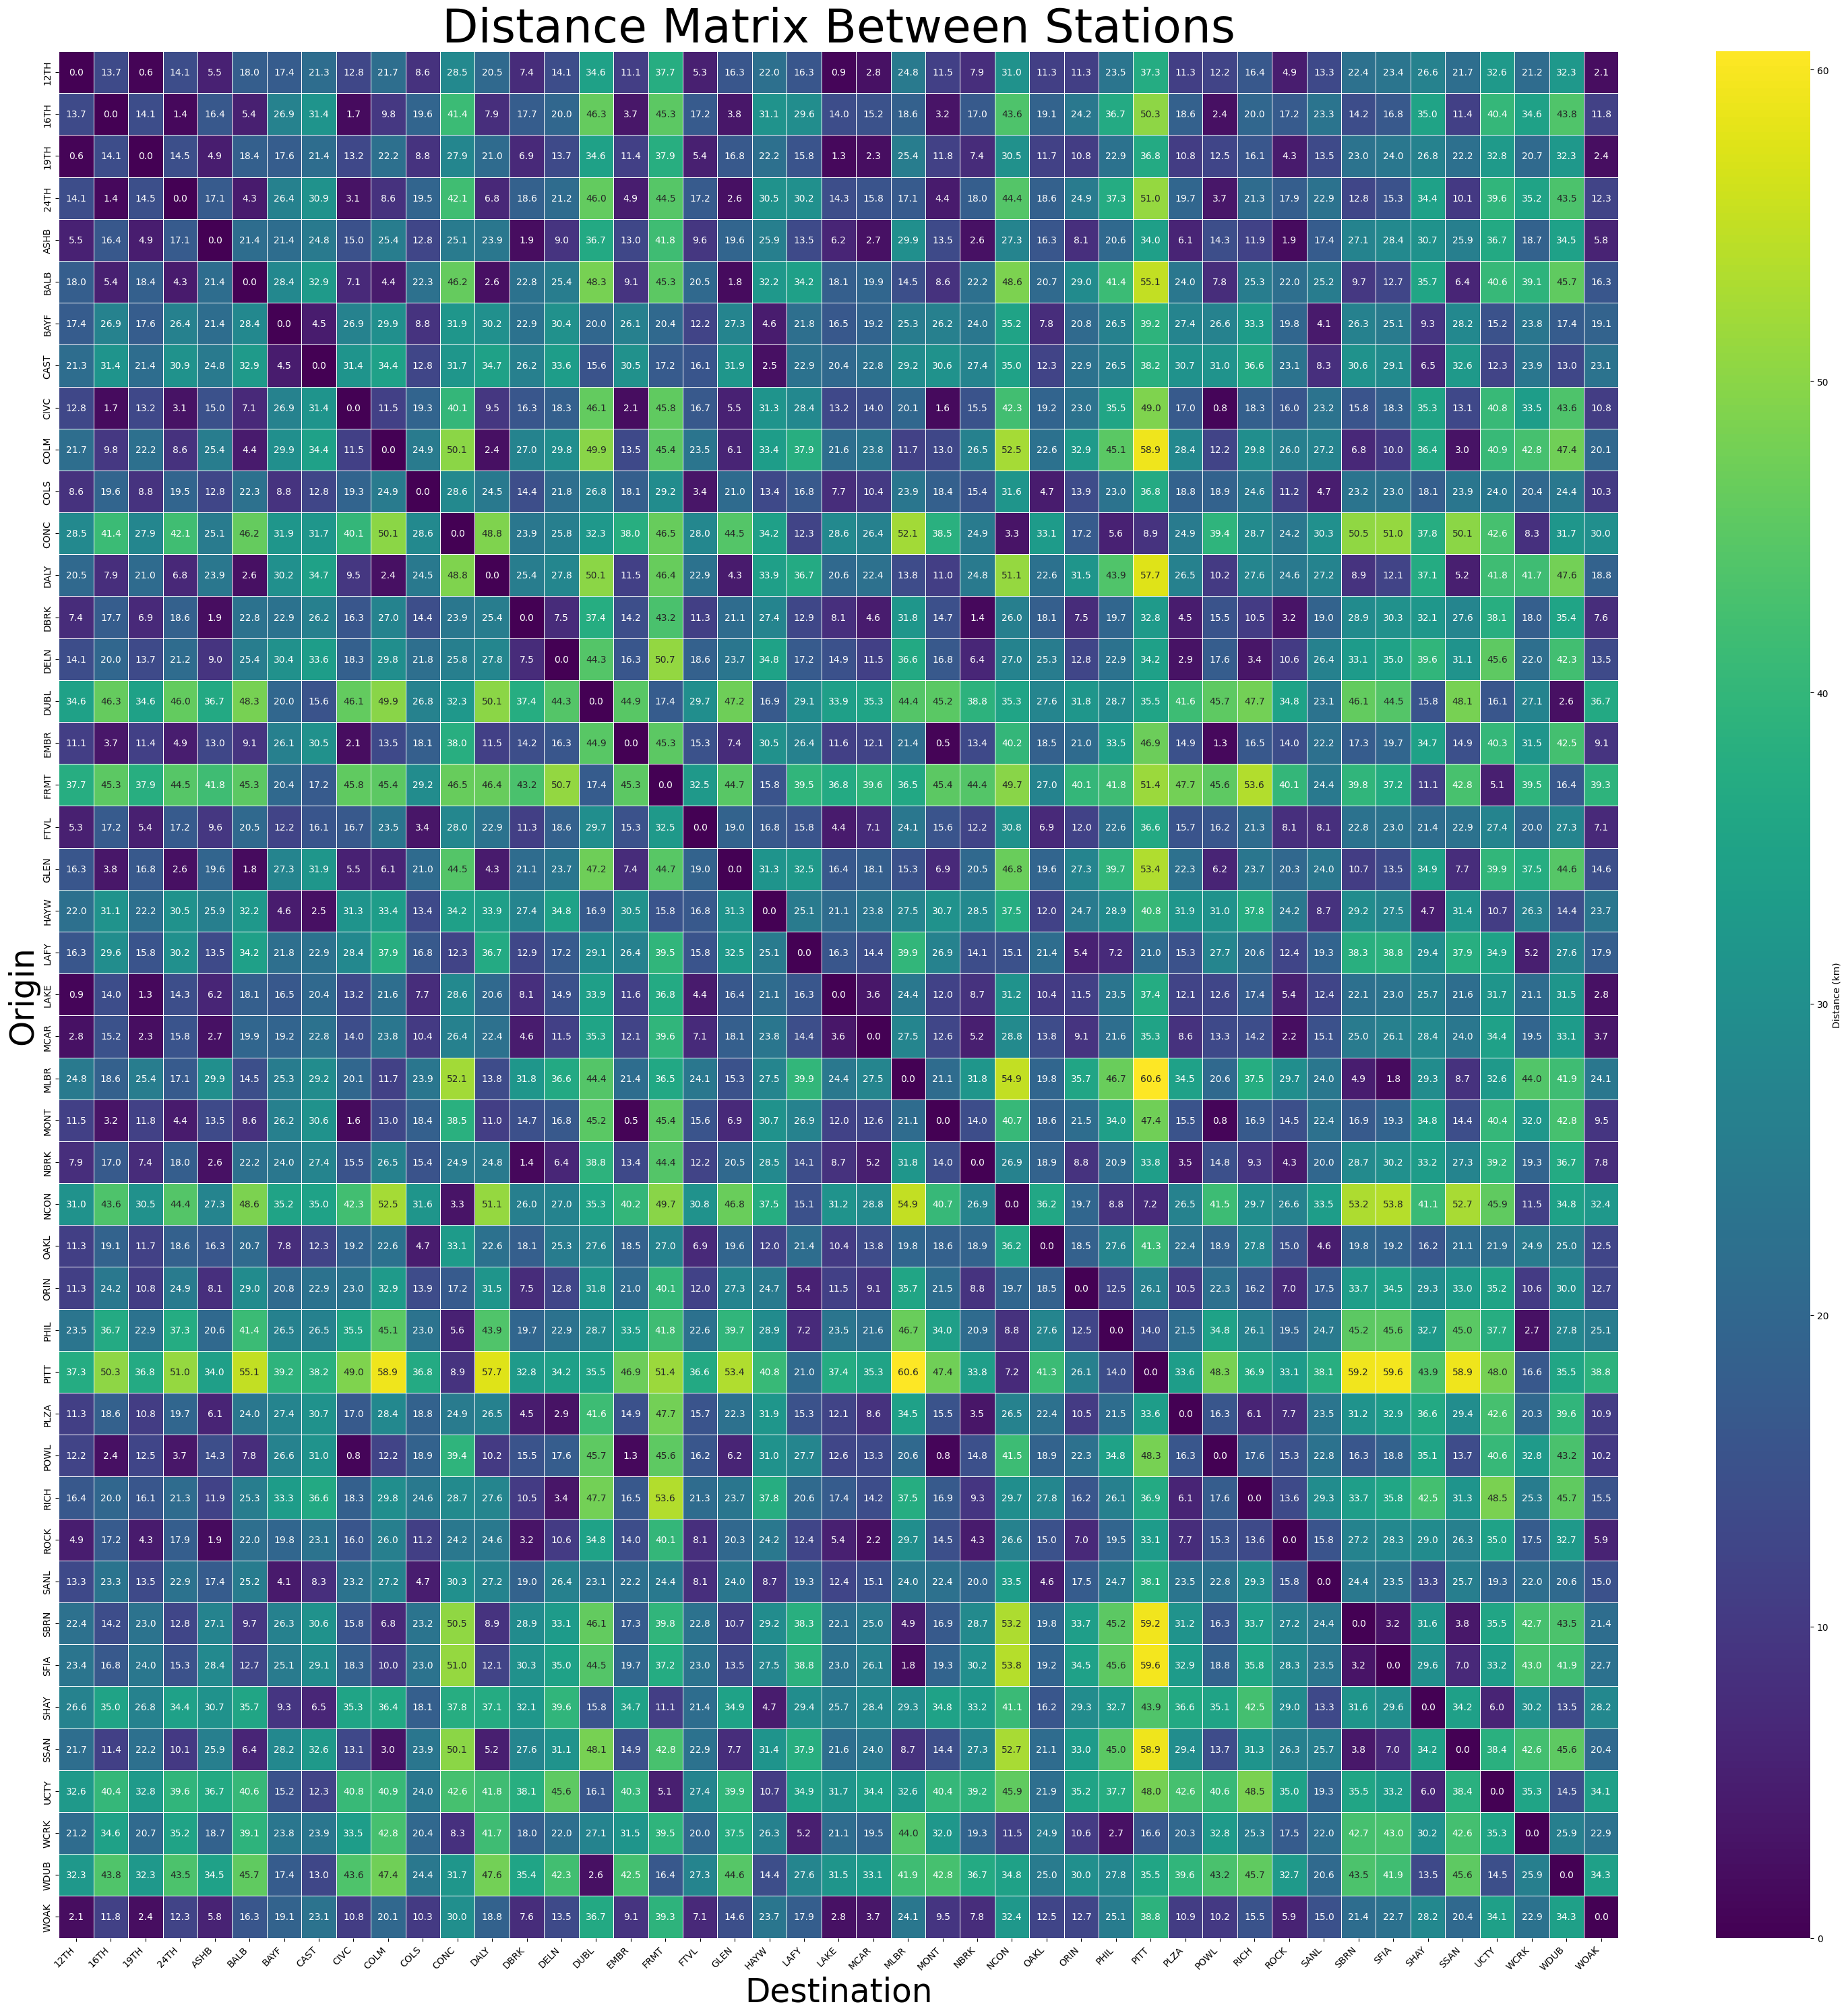

In [46]:
#distance matrix between stations
plt.figure(figsize=(30, 30))
sns.heatmap(df_dist_matrix, annot=True, fmt=".1f", cmap='viridis', cbar_kws={'label': 'Distance (km)'}, linewidths=.5)
plt.title('Distance Matrix Between Stations', fontsize=50)
plt.xlabel('Destination', fontsize=35)
plt.ylabel('Origin', fontsize=35)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Building a model that can predict the number of people commuting to work by Bart between any 2 stations

- ***How would you approach that?***

  I considered weekdays as the working days and defined the commuting times in the morning as 07:00-08:00 and the return times in the evening as 17:00-18:00.

  That is, on Monday, Tuesday, Wednesday, Thursday, and Friday, I will extract the morning commuting and evening return times from the dataframe and assign them to `filtered_df`.

In [30]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_weekdays = df[df['Day'].isin(weekdays)]

morning_filter = df_weekdays['Hour'].isin([7, 8])
evening_filter = df_weekdays['Hour'].isin([17, 18])
filtered_df = df_weekdays[morning_filter | evening_filter]

In [31]:
filtered_df.head()

,Origin,Destination,Throughput,Year,Month,Day,Hour,Longitude,Latitude,Route,la_radians,lo_radians
132,12TH,16TH,1,2016,January,Friday,8,-122.27145,37.803768,12TH - 16TH,0.6598,-2.134039
133,12TH,19TH,1,2016,January,Friday,8,-122.27145,37.803768,12TH - 19TH,0.6598,-2.134039
134,12TH,24TH,1,2016,January,Friday,8,-122.27145,37.803768,12TH - 24TH,0.6598,-2.134039
135,12TH,ASHB,1,2016,January,Friday,8,-122.27145,37.803768,12TH - ASHB,0.6598,-2.134039
136,12TH,BALB,2,2016,January,Friday,8,-122.27145,37.803768,12TH - BALB,0.6598,-2.134039


In [32]:
filtered_df.groupby(['Route', 'Hour'])['Throughput'].sum()

Route        Hour
12TH - 12TH  7          675
             8         1368
             17        1738
             18        1178
12TH - 16TH  7         4959
             8        10245
             17       16328
             18       15242
12TH - 19TH  7         1460
             8         1748
             17        1921
             18        1450
12TH - 24TH  7         3009
             8         4306
             17       19220
             18       17939
12TH - ASHB  7         1743
             8         2826
             17       19264
             18       13126
12TH - BALB  7         2557
             8         2228
             17       11713
             18        7138
12TH - BAYF  7         1602
             8         1061
             17       32753
             18       15620
12TH - CAST  7          167
             8          146
             17       12184
             18        7553
12TH - CIVC  7        19325
             8        37307
             17       29094
  

In [33]:
filtered_df.head()

,Origin,Destination,Throughput,Year,Month,Day,Hour,Longitude,Latitude,Route,la_radians,lo_radians
132,12TH,16TH,1,2016,January,Friday,8,-122.27145,37.803768,12TH - 16TH,0.6598,-2.134039
133,12TH,19TH,1,2016,January,Friday,8,-122.27145,37.803768,12TH - 19TH,0.6598,-2.134039
134,12TH,24TH,1,2016,January,Friday,8,-122.27145,37.803768,12TH - 24TH,0.6598,-2.134039
135,12TH,ASHB,1,2016,January,Friday,8,-122.27145,37.803768,12TH - ASHB,0.6598,-2.134039
136,12TH,BALB,2,2016,January,Friday,8,-122.27145,37.803768,12TH - BALB,0.6598,-2.134039


In [34]:
filtered_df['Throughput'].sum()

61088924

In [35]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2379417 entries, 132 to 13269638
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Origin       object 
 1   Destination  object 
 2   Throughput   int64  
 3   Year         int32  
 4   Month        object 
 5   Day          object 
 6   Hour         int32  
 7   Longitude    float64
 8   Latitude     float64
 9   Route        object 
 10  la_radians   float64
 11  lo_radians   float64
dtypes: float64(4), int32(2), int64(1), object(5)
memory usage: 217.8+ MB


### Modelling Deep Learning for Regression

In [36]:
x = filtered_df.drop ('Throughput', axis=1)
y = filtered_df['Throughput']

x = pd.get_dummies(x, columns=['Origin', 'Destination','Month','Day', 'Route'])

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42)

model=Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mse')

In [38]:
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=512, epochs=15)

Epoch 1/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 2892.0015 - val_loss: 1964.5769
Epoch 2/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 1835.0438 - val_loss: 468.6989
Epoch 3/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 525.4537 - val_loss: 420.9910
Epoch 4/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 416.7962 - val_loss: 425.8319
Epoch 5/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 372.4532 - val_loss: 280.0770
Epoch 6/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 324.0123 - val_loss: 589.3875
Epoch 7/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 334.1623 - val_loss: 401.9790
Epoch 8/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 335.7506 - val_loss: 275.8148
Epoch 9/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 312.1390 - val_loss: 317.5117
Epoch 10/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 304.8905 - val_loss: 309.0878
Epoch 11/15
3718/3718 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 31

In [39]:
pred=model.predict(x_test)

14872/14872 ━━━━━━━━━━━━━━━━━━━━ 5s 348us/step


R²: 0.9345545432297345


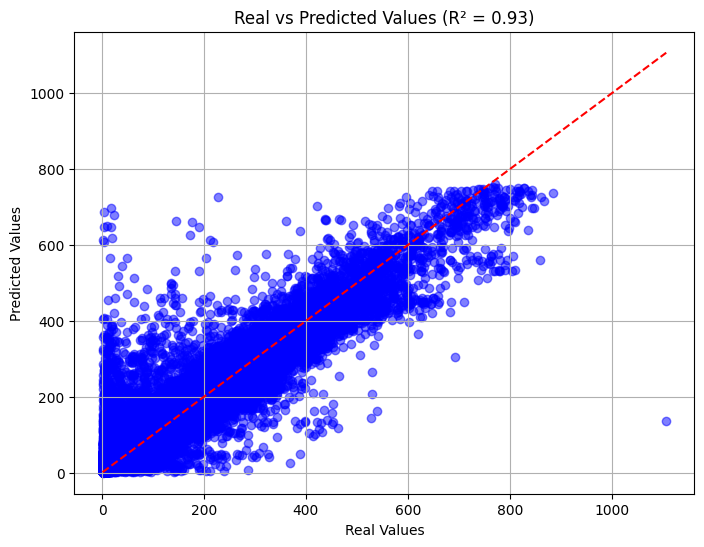

In [40]:
r_squared=r2_score(y_test, pred)
print(f"R²: {r_squared}")

#real vs predicted values graph
plt.figure(figsize=(8, 6))
plt.scatter(y_test, pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Real vs Predicted Values (R² = {r_squared:.2f})')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

In [41]:
mean_squared_error(y_test, pred)**.5

15.399926501239774

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │       218,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,665 (2.61 MB)

 Trainable params: 228,221 (891.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 456,444 (1.74 MB)

<Axes: >

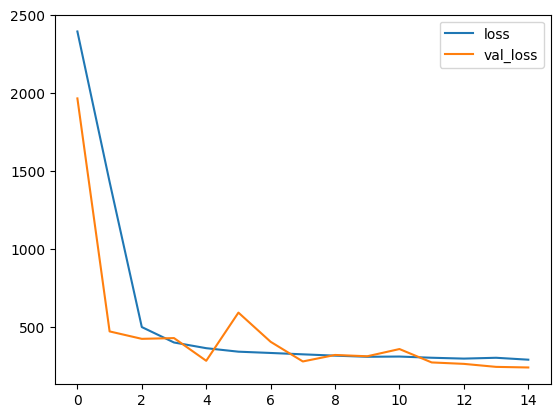

In [43]:
#model loss visualization
loss_f=pd.DataFrame(history.history)
loss_f.plot()

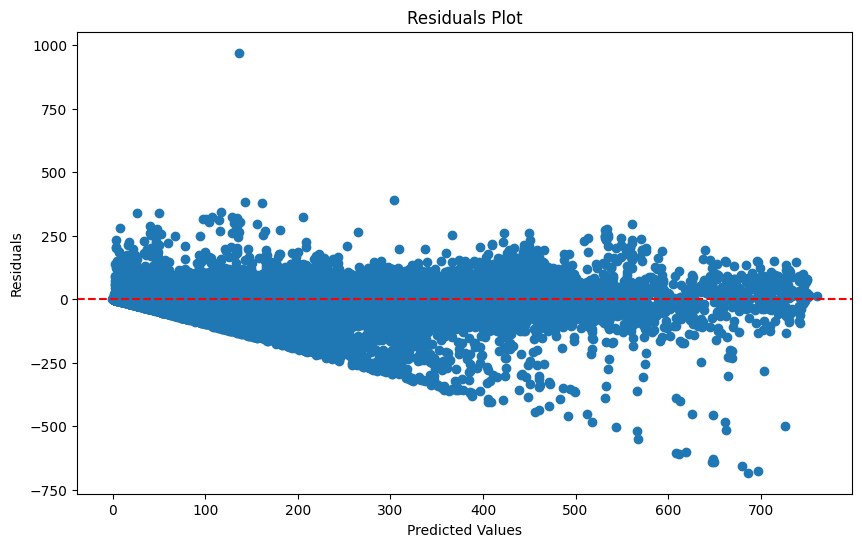

In [45]:
#residuals vs. predicted values
residuals = y_test - pred.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

- ***What additional data would you need?***

  In this project, even if it didn't include personal data, if we had an identifier for each passenger (such as kind of unique number showing which days a person used the metro and how many times), we could have prepared our regression model calculating commuters more accurately and achieved better results.

- ***How would you want the city or Bart officials to use your data?***
  
    City and Bart officials can effectively utilize the deep learning regression model. Applications include transportation planning, resource allocation, and infrastructure development.
  
    The model can help adjust service frequency during peak hours, optimize routes, allocate staff and vehicles efficiently, and implement dynamic pricing.